In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import celerite2
import celerite2.theano
from celerite2.theano import terms as theano_terms
import pymc3 as pm
import seaborn as sns

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

Let's try a pretty simple example: we want to find two sharp QPOs that are very close to each other (compared to their central frequency).  We choose parameters that are at least not insane given typical values for the small frequency spacing of asteroseismic modes.

In [3]:
sigma_mode1 = 1.0
sigma_mode2 = 2.0
sigma_obs = 1.0

f0 = 1.0 # This would be ~10 minutes for solar-type stars.
df0 = 1.0 / (6.0 * 24.0 * 30.0) # This is ~1/(1 month) relative to 1/(10 min)
Q0 = f0 / df0 * 10 # So the modes are well-separated

freqs = linspace(f0-2*df0, f0+2*df0, 1024)
omegas = 2*pi*freqs

In [4]:
gp = celerite2.GaussianProcess(celerite2.terms.SHOTerm(sigma=sigma_mode1, Q=Q0, w0=2*pi*(f0-df0/2)) + celerite2.terms.SHOTerm(sigma=sigma_mode2, Q=Q0, w0=2*pi*(f0 + df0/2)))

Let's plot over a short period of observation:

Text(0, 0.5, '$y$')

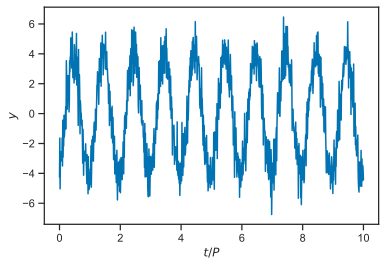

In [5]:
ts = linspace(0, 10 / f0, 1024)
gp.compute(ts, yerr=sigma_obs)
plot(ts, gp.sample())
xlabel(r'$t / P$')
ylabel(r'$y$')

What about over a very, very long time (in the units above, this is 1 "year" of observations).  The sampling is pretty sparse (only 1024 samples, even though there are vastly more cycles).  

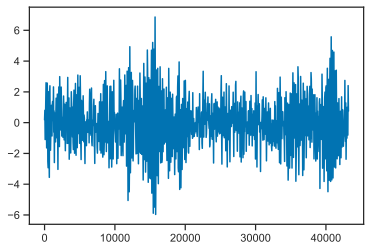

In [6]:
ts = linspace(0, Q0 / f0, 1024)
gp.compute(ts, yerr=sigma_obs)
ys = gp.sample()
plot(ts, ys)

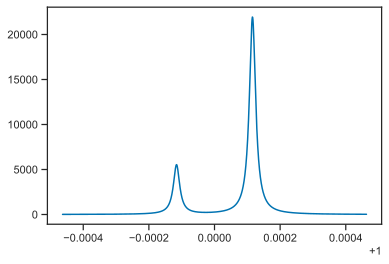

In [7]:
plot(freqs, gp.kernel.get_psd(omegas))

Let's choose a bit smaller data set to fit so that things go quickly:

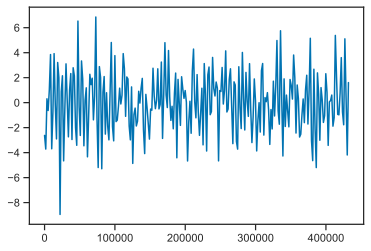

In [8]:
N = 256
ts = linspace(0, 10*Q0 / f0, N)
gp.compute(ts, yerr=sigma_obs)
ys = gp.sample()
plot(ts, ys)

In [9]:
with pm.Model() as model:
    sigma1 = pm.Lognormal('sigma1', mu=log(1), sigma=1, testval=sigma_mode1)
    sigma2 = pm.Lognormal('sigma2', mu=log(1), sigma=1, testval=sigma_mode2)
    
    f_unit = pm.Normal('f_unit', mu=0, sigma=1, testval=0)
    df_unit = pm.HalfNormal('df_unit', sigma=1, testval=0.1)
    
    f = pm.Deterministic('f', f0 + 10*df0*f_unit)
    df = pm.Deterministic('df', 10*df0*df_unit)
    
    Q = pm.Lognormal('Q', mu=log(Q0), sigma=1, testval=Q0)
    
    k1 = theano_terms.SHOTerm(sigma=sigma1, Q=Q, w0=2*pi*(f-df/2))
    k2 = theano_terms.SHOTerm(sigma=sigma2, Q=Q, w0=2*pi*(f+df/2))
    g = celerite2.theano.GaussianProcess(k1+k2)
    g.compute(ts, yerr=sigma_obs)
    g.marginal('obs', observed=ys)
    
    pm.Deterministic('psd', g.kernel.get_psd(omegas))

In [10]:
with model:
    trace = pm.sample(tune=1000, draws=1000, init='adapt_full')

/var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/ipykernel_51764/2841226929.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=1000, draws=1000, init='adapt_full')
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/wfarr/miniconda3/envs/HeterodyneAsteroseismology/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:514: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Q, df_unit, f_unit, sigma2, sigma1]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 50 seconds.


Got error No model on context stack. trying to find log_likelihood in translation.
/Users/wfarr/miniconda3/envs/HeterodyneAsteroseismology/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'f'}>,
        <AxesSubplot:title={'center':'f'}>],
       [<AxesSubplot:title={'center':'df'}>,
        <AxesSubplot:title={'center':'df'}>],
       [<AxesSubplot:title={'center':'sigma1'}>,
        <AxesSubplot:title={'center':'sigma1'}>],
       [<AxesSubplot:title={'center':'sigma2'}>,
        <AxesSubplot:title={'center':'sigma2'}>],
       [<AxesSubplot:title={'center':'Q'}>,
        <AxesSubplot:title={'center':'Q'}>]], dtype=object)

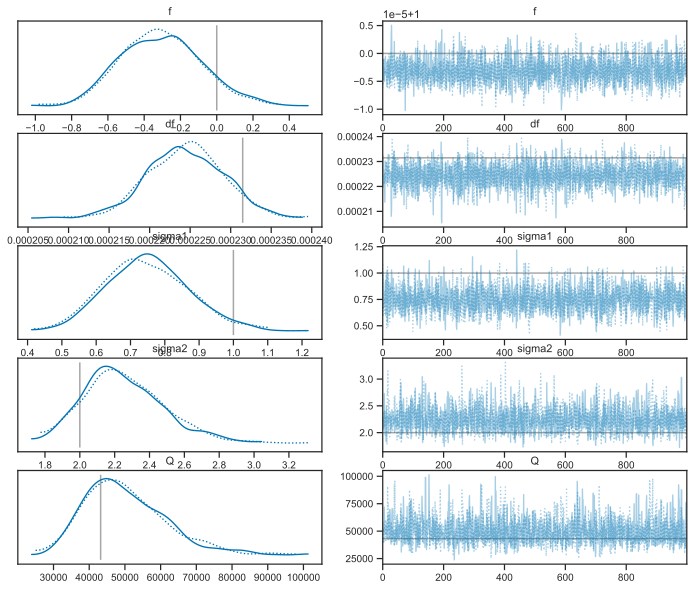

In [11]:
pm.plot_trace(trace, var_names=['f', 'df', 'sigma1', 'sigma2', 'Q'], lines=[('f', {}, f0), ('sigma1', {}, sigma_mode1), ('sigma2', {}, sigma_mode2), ('Q', {}, Q0), ('df', {}, df0)])

Text(0, 0.5, '$P(f)$')

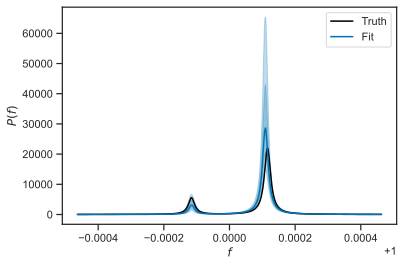

In [12]:
plot(freqs, gp.kernel.get_psd(omegas), color='k', label='Truth')

m, l, h, ll, hh = quantile(trace['psd'], [0.5, 0.16, 0.84, 0.025, 0.975], axis=0)

x, = plot(freqs, m, label='Fit')
fill_between(freqs, h, l, color=x.get_color(), alpha=0.25)
fill_between(freqs, hh, ll, color=x.get_color(), alpha=0.25)

legend(loc='best')

xlabel(r'$f$')
ylabel(r'$P(f)$')

Let's try un-even sampling (this should provide an even *better* constraint on the frequencies---$f_0$, $\delta f$, and $Q$---because the bandwidth of such uneven sampling is larger).

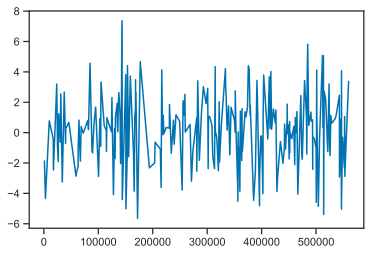

In [13]:
N = 256
Tmax = Q0/f0 # The longest timescale / smallest frequency in the problem
ts = cumsum(random.exponential(scale=Tmax/20, size=N)) # Poisson time sampling, with rate 20/Tmax
gp.compute(ts, yerr=sigma_obs)
ys = gp.sample()
plot(ts, ys)

In [14]:
with pm.Model() as model:
    sigma1 = pm.Lognormal('sigma1', mu=log(1), sigma=1, testval=sigma_mode1)
    sigma2 = pm.Lognormal('sigma2', mu=log(1), sigma=1, testval=sigma_mode2)
    
    f_unit = pm.Normal('f_unit', mu=0, sigma=1, testval=0)
    df_unit = pm.HalfNormal('df_unit', sigma=1, testval=0.1)
    
    f = pm.Deterministic('f', f0 + 10*df0*f_unit)
    df = pm.Deterministic('df', 10*df0*df_unit)
    
    Q = pm.Lognormal('Q', mu=log(Q0), sigma=1, testval=Q0)
    
    k1 = theano_terms.SHOTerm(sigma=sigma1, Q=Q, w0=2*pi*(f-df/2))
    k2 = theano_terms.SHOTerm(sigma=sigma2, Q=Q, w0=2*pi*(f+df/2))
    g = celerite2.theano.GaussianProcess(k1+k2)
    g.compute(ts, yerr=sigma_obs)
    g.marginal('obs', observed=ys)
    
    pm.Deterministic('psd', g.kernel.get_psd(omegas))

In [15]:
with model:
    trace = pm.sample(tune=1000, draws=1000, init='adapt_full')

/var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/ipykernel_51764/2841226929.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(tune=1000, draws=1000, init='adapt_full')
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/wfarr/miniconda3/envs/HeterodyneAsteroseismology/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:514: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Q, df_unit, f_unit, sigma2, sigma1]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 56 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
/Users/wfarr/miniconda3/envs/HeterodyneAsteroseismology/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'f'}>,
        <AxesSubplot:title={'center':'f'}>],
       [<AxesSubplot:title={'center':'df'}>,
        <AxesSubplot:title={'center':'df'}>],
       [<AxesSubplot:title={'center':'sigma1'}>,
        <AxesSubplot:title={'center':'sigma1'}>],
       [<AxesSubplot:title={'center':'sigma2'}>,
        <AxesSubplot:title={'center':'sigma2'}>],
       [<AxesSubplot:title={'center':'Q'}>,
        <AxesSubplot:title={'center':'Q'}>]], dtype=object)

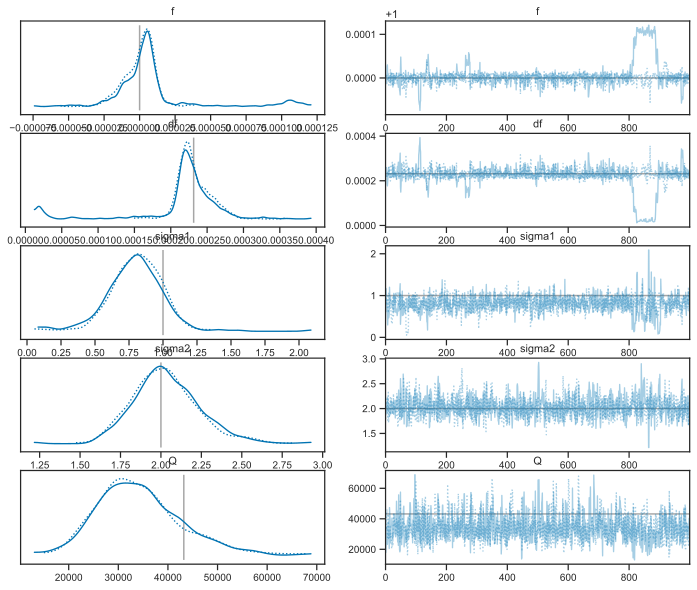

In [16]:
pm.plot_trace(trace, var_names=['f', 'df', 'sigma1', 'sigma2', 'Q'], lines=[('f', {}, f0), ('sigma1', {}, sigma_mode1), ('sigma2', {}, sigma_mode2), ('Q', {}, Q0), ('df', {}, df0)])

Text(0, 0.5, '$P(f)$')

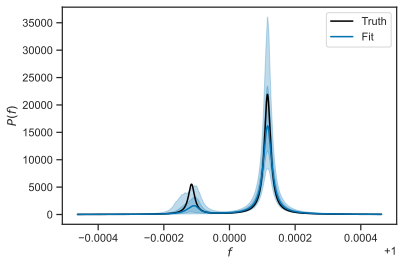

In [17]:
plot(freqs, gp.kernel.get_psd(omegas), color='k', label='Truth')

m, l, h, ll, hh = quantile(trace['psd'], [0.5, 0.16, 0.84, 0.025, 0.975], axis=0)

x, = plot(freqs, m, label='Fit')
fill_between(freqs, h, l, color=x.get_color(), alpha=0.25)
fill_between(freqs, hh, ll, color=x.get_color(), alpha=0.25)

legend(loc='best')

xlabel(r'$f$')
ylabel(r'$P(f)$')

Let's try something realistic.  This is the [Kjeldsen & Bedding (2011)](http://dx.doi.org/10.1051/0004-6361/201116789) relation applied to Aldebaran, and also a (very conservative) guess from [Farr, et al. (2018)](https://doi.org/10.3847/2041-8213/aadfde).

In [18]:
A_sun = 0.2 # m/s
Laldeb = 439 # LSun
Maldeb = 1.16 # MSun
Taldeb = 3900 # K
TSun = 5800 # K

A_aldeb_scaling = Laldeb / (Maldeb**1.5*(Taldeb/TSun)**2.25)
A_aldeb = 60.0 # 170 m/s is the RMS amplitude from Farr+(2018), but who knows how many modes it contains....
A_aldeb_scaling, A_aldeb

(858.21313294463, 60.0)

In [19]:
numax_aldeb = 2.33 # muHz
Dnu_sun = 135.0 # muHz
Dnu_aldeb = (Maldeb)**0.5*(Taldeb/TSun)**3/(Laldeb)**0.75*Dnu_sun
dnu_aldeb = 0.12*Dnu_aldeb
(numax_aldeb, Dnu_aldeb, dnu_aldeb)

(2.33, 0.4609185779612971, 0.05531022935535565)

In [20]:
Q_aldeb = 10 * numax_aldeb / dnu_aldeb # Ensure that the modes are narrow enough
Q_aldeb

421.26023109220534

In [21]:
mu_Hz_day = 1/(24.0*3600.0)*1e6

In [22]:
T = 2/(dnu_aldeb/mu_Hz_day)
print('T = {:.1f} d or {:.1f} yr'.format(T, T/365.25))

T = 418.5 d or 1.1 yr


In [23]:
sigma_song = 2.4 # m/s on Aldebaran

In [24]:
gp_aldeb = celerite2.GaussianProcess(celerite2.terms.SHOTerm(sigma=A_aldeb, Q=Q_aldeb, w0=2*pi*(numax_aldeb/mu_Hz_day)) + celerite2.terms.SHOTerm(sigma=A_aldeb, Q=Q_aldeb, w0=2*pi*((numax_aldeb+dnu_aldeb)/mu_Hz_day)))

In [25]:
ts_aldeb = sort(random.uniform(low=0, high=T, size=52))

In [26]:
gp_aldeb.compute(ts_aldeb, yerr=sigma_song)
ys_aldeb = gp_aldeb.sample()

Text(0, 0.5, '$v_r / \\mathrm{m} \\, \\mathrm{s}^{-1}$')

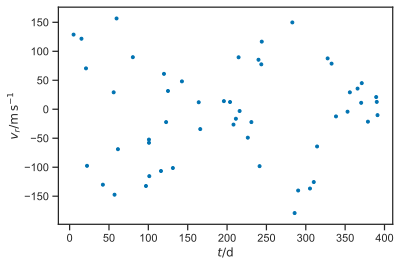

In [27]:
errorbar(ts_aldeb, ys_aldeb, yerr=sigma_song, fmt='.')
xlabel(r'$t / \mathrm{d}$')
ylabel(r'$v_r / \mathrm{m} \, \mathrm{s}^{-1}$')

In [28]:
omegas_aldeb = 2*pi*linspace((numax_aldeb-10*dnu_aldeb)/mu_Hz_day, (numax_aldeb+10*dnu_aldeb)/mu_Hz_day, 1024)
with pm.Model() as model_aldeb:
    sigma1 = pm.Lognormal('sigma1', mu=log(A_aldeb), sigma=1)
    sigma2 = pm.Lognormal('sigma2', mu=log(A_aldeb), sigma=1)
    
    f_unit = pm.Normal('f_unit', mu=0, sigma=1, testval=0)
    df_unit = pm.HalfNormal('df_unit', sigma=1, testval=0.1)
    
    f = pm.Deterministic('f', (numax_aldeb + (f_unit + 0.5)*dnu_aldeb)/mu_Hz_day)
    df = pm.Deterministic('df', df_unit*dnu_aldeb/mu_Hz_day)
    
    Q = pm.Lognormal('Q', mu=log(Q_aldeb), sigma=1)
    
    k1 = theano_terms.SHOTerm(sigma=sigma1, Q=Q, w0=2*pi*(f-df/2))
    k2 = theano_terms.SHOTerm(sigma=sigma2, Q=Q, w0=2*pi*(f+df/2))
    g = celerite2.theano.GaussianProcess(k1+k2)
    g.compute(ts_aldeb, yerr=sigma_song)
    g.marginal('obs', observed=ys_aldeb)
    
    pm.Deterministic('psd', g.kernel.get_psd(omegas_aldeb))

In [29]:
with model_aldeb:
    trace_aldeb = pm.sample(tune=1000, draws=1000, init='adapt_full')

/var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/ipykernel_51764/2116391753.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_aldeb = pm.sample(tune=1000, draws=1000, init='adapt_full')
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/wfarr/miniconda3/envs/HeterodyneAsteroseismology/lib/python3.9/site-packages/pymc3/step_methods/hmc/quadpotential.py:514: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Q, df_unit, f_unit, sigma2, sigma1]


RuntimeError: Chain 1 failed.

Text(0, 0.5, '$P(f)$')

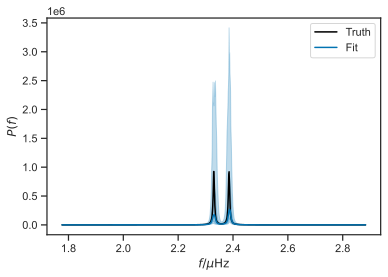

In [48]:
plot(omegas_aldeb/(2*pi)*mu_Hz_day, gp_aldeb.kernel.get_psd(omegas_aldeb), color='k', label='Truth')

m, l, h, ll, hh = quantile(trace_aldeb['psd'], [0.5, 0.16, 0.84, 0.025, 0.975], axis=0)

x, = plot(omegas_aldeb/(2*pi)*mu_Hz_day, m, label='Fit')
fill_between(omegas_aldeb/(2*pi)*mu_Hz_day, h, l, color=x.get_color(), alpha=0.25)
fill_between(omegas_aldeb/(2*pi)*mu_Hz_day, hh, ll, color=x.get_color(), alpha=0.25)

legend(loc='best')

xlabel(r'$f / \mu\mathrm{Hz}$')
ylabel(r'$P(f)$')

/Users/wfarr/miniconda3/envs/HeterodyneAsteroseismology/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'sigma1'}>,
        <AxesSubplot:title={'center':'sigma1'}>],
       [<AxesSubplot:title={'center':'sigma2'}>,
        <AxesSubplot:title={'center':'sigma2'}>],
       [<AxesSubplot:title={'center':'f'}>,
        <AxesSubplot:title={'center':'f'}>],
       [<AxesSubplot:title={'center':'df'}>,
        <AxesSubplot:title={'center':'df'}>],
       [<AxesSubplot:title={'center':'Q'}>,
        <AxesSubplot:title={'center':'Q'}>]], dtype=object)

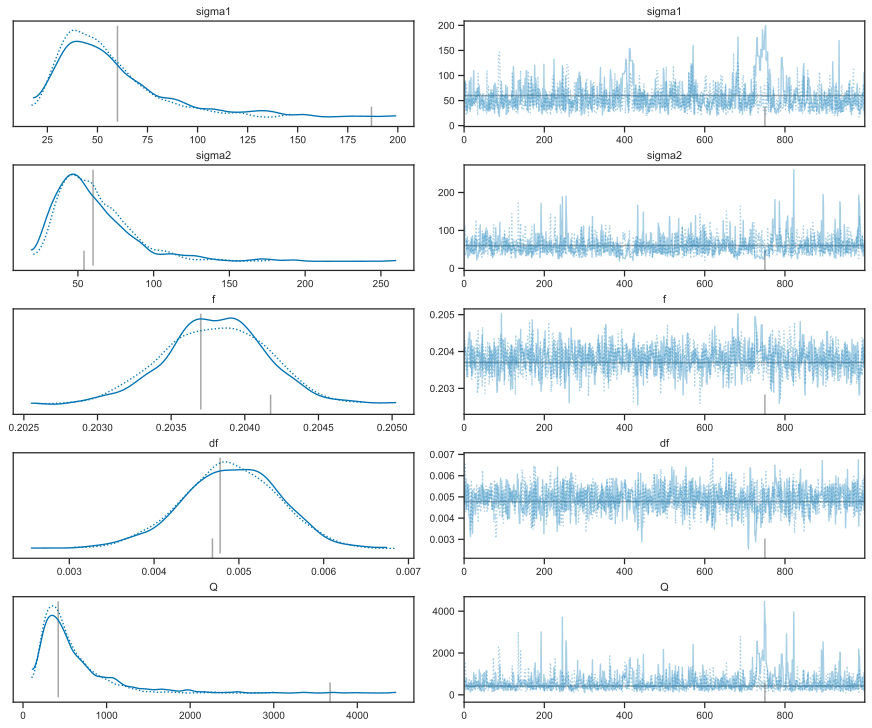

In [49]:
pm.plot_trace(trace_aldeb, 
              var_names = ['sigma1', 'sigma2', 'f', 'df', 'Q'],
              lines=[('sigma1', {}, A_aldeb),
                     ('sigma2', {}, A_aldeb),
                     ('f', {}, (numax_aldeb + dnu_aldeb/2)/mu_Hz_day), 
                     ('Q', {}, Q_aldeb),
                     ('df', {}, dnu_aldeb/mu_Hz_day)])